In [1]:
import numpy as np 
from scipy import stats 
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.colors as colors
import sys
from iminuit import Minuit
import pandas as pd

from functools import lru_cache
from iminuit.cost import UnbinnedNLL
from iminuit.util import make_with_signature


In [2]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [3]:
def setMplParam(classNum):
    COLOUR = ['#1E90FF', '#FFBF00', '#FF6347', '#00A86B', '#5A4FCF','#D473D4', '#00CCFF']
    LINE = ['--', '-', '-.', '-', ':', '--','-']
    MARKER = ['o', '*', '^', 's', '.', 'p', 'o']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                        plt.cycler(linestyle=LINE_EFF) +
                                        plt.cycler(marker=MARKER_EFF))
    plt.rcParams['lines.markersize'] = 5  # Example size
    plt.rcParams['lines.linewidth'] = 2  # Example width

    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20
    
    plt.rcParams['legend.fontsize'] = 12

    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    mpl.rcParams['axes.linewidth'] = 2

    mpl.rcParams['xtick.major.size'] = 7
    mpl.rcParams['xtick.major.width'] = 3
    mpl.rcParams['xtick.minor.size'] = 2
    mpl.rcParams['xtick.minor.width'] = 2

    mpl.rcParams['ytick.major.size'] = 7
    mpl.rcParams['ytick.major.width'] = 3
    mpl.rcParams['ytick.minor.size'] = 2
    mpl.rcParams['ytick.minor.width'] = 2

setMplParam(6)

In [4]:
def readData(file):
    # Specify header=None to indicate the first row is not a header
    # Add column names manually if desired, for example, ['Value']
    data = pd.read_csv(file, header=None)
    if data.shape[0] < 2000:
        rows_to_add = 2000 - data.shape[0]
        additional_rows = pd.DataFrame(np.nan, index=range(rows_to_add), columns=data.columns)
        data = pd.concat([data, additional_rows], ignore_index=True)

    return data

data1 = readData('data1.dat')
bound1 = (-0.95, 0.95)
print(data1.head())

          0
0 -0.123539
1 -0.035415
2  0.150512
3  0.730207
4  0.791910


In [5]:
def getHistoParam(data):
    Nbins = int(np.sqrt(data.shape[0]))
    counts, x_edges = np.histogram(data, bins=Nbins)
    binwidth = x_edges[1] - x_edges[0]
    x_centres = x_edges[:-1] + binwidth/2
    return Nbins, binwidth, counts, x_centres

In [6]:
@lru_cache(maxsize = None)
def integrateMC(f, bound, *par):
    N = 10000
    x = np.random.uniform(bound[0], bound[1], N)
    fx = f(x, *par)
    y = np.random.uniform(0, np.max(fx), N)
    ratio = np.sum(y < fx) / N
    norm = ratio * (bound[1] - bound[0]) * np.max(fx)
    return norm

In [7]:
def scalePdf(pdf, data):
    # handle the binning
    Ndata = data.shape[0]
    _, binwidth, _, _ = getHistoParam(data)
    scaleFactor = Ndata * binwidth
    def scaledPdf(x, alpha, beta):
        return pdf(x, alpha, beta) * scaleFactor
    
    return scaledPdf

In [8]:
def unnormal_quadratic(x, alpha, beta):
    return alpha * x**2 + beta*x + 1

In [42]:
def normal_quadratic(x, alpha, beta):
    return unnormal_quadratic(x, alpha, beta) / integrateMC(unnormal_quadratic, bound1, alpha, beta)

In [43]:
def scale_normal_quadratic(x, N, alpha, beta):
    return N * normal_quadratic(x, alpha, beta)

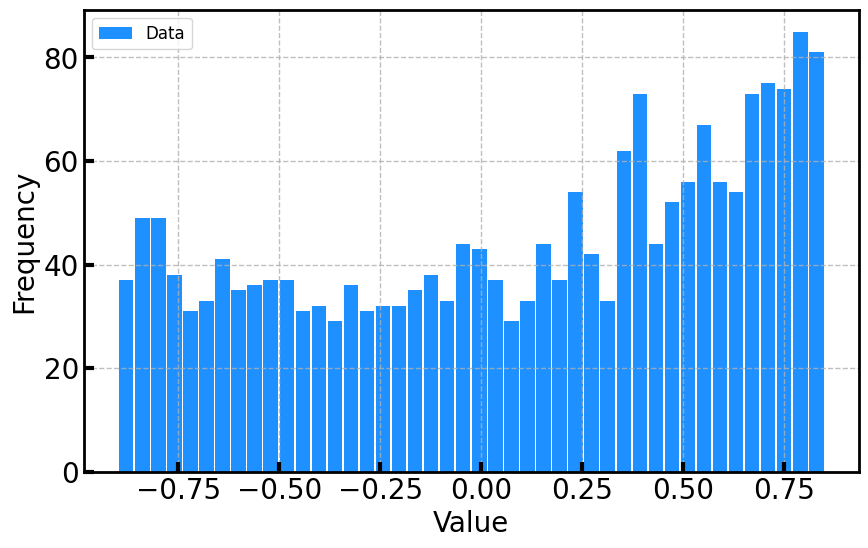

In [36]:
def plotHisto(data):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    Nbins, binwidth, counts, x_centres = getHistoParam(data)
    
    xMax = 0.95 or  bound1[1]
    xMin = -0.95 or bound1[0]

    x_axis = np.linspace(bound1[0], bound1[1], 100)
    ax.hist(data, bins=Nbins, histtype='bar', label='Data', rwidth=0.9)
    # scaledPdf = scalePdf(normal_quadratic, data)
    # ax.plot(x_axis, scaledPdf(x_axis, 0.5, 0.5), label='Scaled PDF')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()
plotHisto(data1)  

In [39]:
def ln_likelihood_core(data, alpha, beta):
    return np.sum(np.log(normal_quadratic(data, alpha, beta)))

def ln_likelihood(alpha, beta):
    return - ln_likelihood_core(data1, alpha, beta)


In [26]:
def scanAlphaBeta():
    RESOLUTION = 10
    alphas = np.linspace(0.1, 1.2, RESOLUTION)
    betas = np.linspace(0.1, 1.2, RESOLUTION)
    likelihoods = np.zeros((len(alphas), len(betas)))
    min_alpha = 0
    min_beta = 0
    min_llh = 2000
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            likelihoods[i, j] = ln_likelihood(alpha, beta)
            if likelihoods[i, j] < min_llh:
                min_llh = likelihoods[i, j]
                min_alpha = alpha
                min_beta = beta
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    c = ax.contourf(alphas, betas, likelihoods, levels=20, cmap='GnBu')
    ax.plot(min_alpha, min_beta, color = 'tomato')
    fig.colorbar(c, ax=ax)
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Beta')
    ax.set_title('Likelihood scan')
    d = {'Alpha': min_alpha, 'Beta': min_beta, 'Likelihood': min_llh}
    add_text_to_ax(0.02, 0.95, nice_string_output(d), ax, fontsize=12)
    plt.show()
    return min_alpha, min_beta

In [44]:
def minimiseLLH(data):
    ullh = UnbinnedLH(scale_normal_quadratic, data=data1, bound=bound1)
    minuit = Minuit(ullh, N = 2000, alpha=0.5, beta=0.5)
    minuit.migrad()
    print(minuit.migrad())

    # 0.64
    
minimiseLLH(data1)
    



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3.703e+04                 │              Nfcn = 406              │
│ EDM = 7.97e+07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

In [15]:
def 

SyntaxError: invalid syntax (1885169875.py, line 1)